Based off of
https://colab.research.google.com/drive/1njyOjtWLvh1zB6yvftcntD-qhwszTOW3.

### Load libraries

In [1]:
import dataclasses
import pathlib
import sys
from typing import Any

import cuml.neighbors.kneighbors_regressor
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))
from src import stylesheets
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.probes import knn_probe

### Helper functions

In [2]:
@dataclasses.dataclass
class Dataset:
    xs: np.ndarray
    ys: np.ndarray

    def __post_init__(self):
        assert self.xs.shape[0] == self.ys.shape[0]
        assert self.xs.ndim == 2
        assert self.ys.ndim == 1


@dataclasses.dataclass
class DataParams:
    w_true: np.ndarray
    sigma: float

    def __post_init__(self):
        assert self.w_true.ndim == 1
        assert self.sigma >= 0

    @property
    def d(self) -> int:
        return self.w_true.shape[0]

    def gen_data(self, n: int) -> Dataset:
        """y = w_true @ x + N(0, sigma^2)"""
        (d,) = self.w_true.shape
        xs = np.random.normal(size=(n, d))
        ys = xs @ self.w_true + np.random.normal(size=(n,), scale=self.sigma)
        return Dataset(xs=xs, ys=ys)

    def get_opt_lam(self) -> float:
        """
        Returns the optimal lambda for ridge regression.
        See https://arxiv.org/pdf/2003.01897.pdf#lemma.2.
        """
        return self.d * (self.sigma**2) / (np.linalg.norm(self.w_true) ** 2)  # type: ignore


def est_w(
    ds: Dataset,
    lam: float,
) -> np.ndarray:
    """
    Returns argmin_w ||y - Xw||^2 + lam ||w||^2

    Adapted from https://arxiv.org/pdf/2003.01897.pdf.
    """
    (n, d) = ds.xs.shape
    assert ds.ys.shape == (n,)
    assert lam >= 0

    X, y = ds.xs, ds.ys

    # Compute the matrix A = X^T X + lam I
    A = X.T @ X + lam * np.eye(d)

    # Compute the vector b = X^T y
    b = X.T @ y

    # Solve the linear system A w = b
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w

### Generate data

In [3]:
def gen_n_trains(max: int):
    base = 1
    while True:
        for i in range(1, 10):
            ret = base * i
            if ret >= max:
                yield max
                return
            else:
                yield ret
        base *= 10


def run_experiment(
    dims: int = 100,
    sigma: float = 0.1,
    n_trains: list[int] = [],
    n_trials: int = 50,
    n_test: int = 1000,
    seed: int = 0,
) -> pd.DataFrame:
    dp = DataParams(
        w_true=np.array([1] + [0 for _ in range(dims - 1)], dtype=np.float32),
        sigma=sigma,
    )

    np.random.seed(seed)
    results: list[dict[str, Any]] = []

    for n in tqdm(n_trains):
        for i in range(n_trials):
            ds = dp.gen_data(n=n)
            lam = dp.get_opt_lam()

            w_map = est_w(ds=ds, lam=lam)
            w_mle = est_w(ds=ds, lam=0)

            res_dict = dict(
                map_mse=np.linalg.norm(w_map - dp.w_true) ** 2,  # type: ignore
                mle_mse=np.linalg.norm(w_mle - dp.w_true) ** 2,  # type: ignore
                n_train=n,
                trial=i,
                seed=seed,
                sigma=sigma,
                n_test=n_test,
            )

            # k-NN regression baseline
            ds_test = dp.gen_data(n=n_test)
            for n_neighbors in [1, 3, 10]:
                knn_clf = (
                    cuml.neighbors.kneighbors_regressor.KNeighborsRegressor(
                        n_neighbors=1, weights="uniform"
                    )
                )
                knn_clf.fit(ds.xs, ds.ys)
                knn_ys = knn_clf.predict(ds_test.xs)
                knn_mse = ((knn_ys - ds_test.ys) ** 2).mean()
                res_dict[f"knn_{n_neighbors}_mse"] = knn_mse

            results.append(res_dict)

    return pd.DataFrame(results)

In [4]:
# Reproducing plot in https://arxiv.org/pdf/2003.01897.pdf#figure.caption.1
df = run_experiment(
    dims=100,
    sigma=0.1,
    n_trains=sorted(
        list(set(gen_n_trains(max=100 * 100)) | set(range(1, 200)))
    ),
    n_trials=50,
    n_test=1000,
    seed=0,
)

  0%|          | 0/217 [00:00<?, ?it/s]

In [5]:
df_small = run_experiment(
    dims=5,
    sigma=0,
    n_trains=list(gen_n_trains(max=30_000)),
    n_trials=50,
    n_test=1000,
    seed=0,
)

  0%|          | 0/39 [00:00<?, ?it/s]

### Make plots

In [6]:
def fancy_plot(
    df: pd.DataFrame,
    target: str = "err",
    ci: float = 1,
    gb_target: str = "n_train",
    err_irreducible: float = 0.0,
    ci_alpha: float = 0.2,
    **kwargs,
):
    gb = df.groupby(gb_target)

    ax = (gb[target].median() + err_irreducible).plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2) + err_irreducible,
        gb[target].quantile(0.5 + ci / 2) + err_irreducible,
        alpha=ci_alpha,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    return dict(ax=ax, gb=gb)

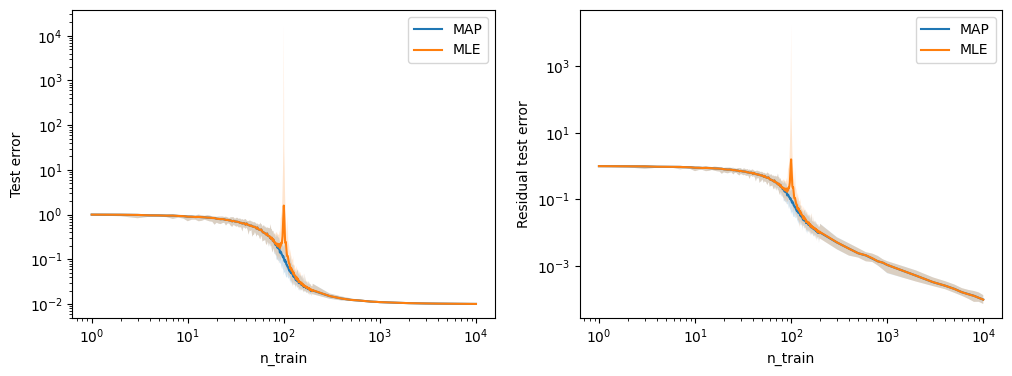

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
fancy_plot(
    df=df, target="map_mse", label="MAP", err_irreducible=df.sigma[0] ** 2
)
fancy_plot(
    df=df, target="mle_mse", label="MLE", err_irreducible=df.sigma[0] ** 2
)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Test error")
plt.legend()

plt.subplot(1, 2, 2)
fancy_plot(df=df, target="map_mse", label="MAP")
fancy_plot(df=df, target="mle_mse", label="MLE")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Residual test error")
plt.legend()

plt.show()

### Paper plots

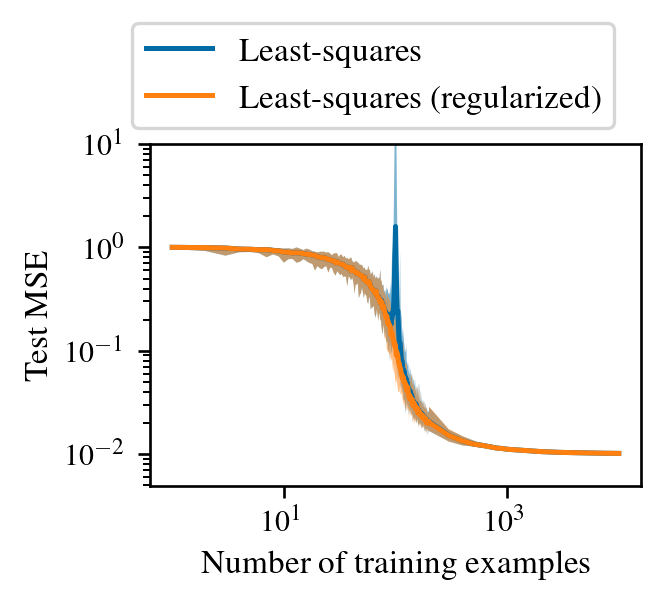

In [19]:
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col2_width"]
plt.figure(figsize=(width, 0.7 * width))

fancy_plot(
    df=df,
    target="mle_mse",
    label="Least-squares",
    err_irreducible=df.sigma[0] ** 2,
    ci_alpha=0.5,
)
fancy_plot(
    df=df,
    target="map_mse",
    label="Least-squares (regularized)",
    err_irreducible=df.sigma[0] ** 2,
    ci_alpha=0.5,
)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Test MSE")
plt.xlabel("Number of training examples")
plt.ylim(top=1e1)
plt.legend(loc="lower left", bbox_to_anchor=(-0.07, 1))

plt.savefig("figures/linreg-noised.pgf", bbox_inches="tight")

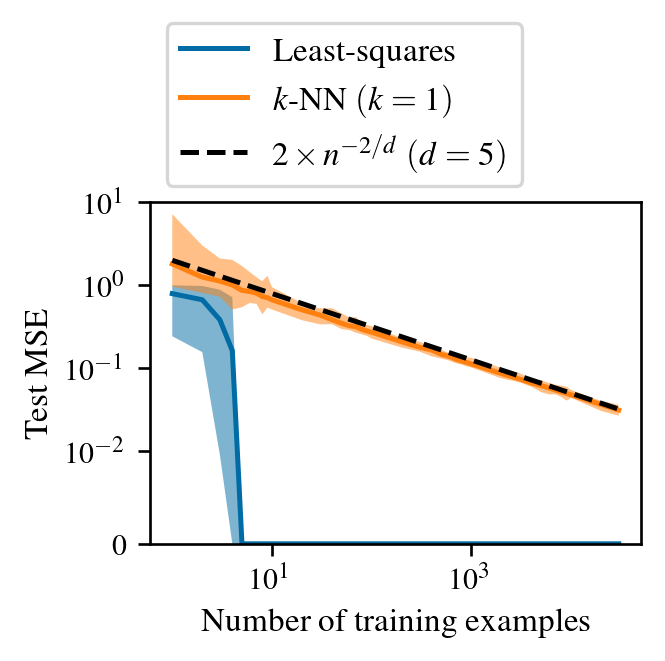

In [9]:
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col2_width"]
plt.figure(figsize=(width, 0.7 * width))

fancy_plot(df=df_small, target="mle_mse", label="Least-squares", ci_alpha=0.5)
fancy_plot(
    df=df_small, target="knn_1_mse", label="$k$-NN $(k=1)$", ci_alpha=0.5
)
plt.plot(
    np.arange(1, 30_000),
    2 * np.arange(1, 30_000) ** -(2 / 5),
    label=r"$2 \times n^{-2/d} \; (d = 5)$",
    linestyle="--",
    color="black",
)
plt.xscale("log")
plt.yscale("symlog", linthresh=1e-2)
plt.ylabel("Test MSE")
plt.ylim(bottom=0, top=1e1)
plt.xlabel("Number of training examples")
plt.legend(loc="lower left", bbox_to_anchor=(0, 1))

plt.savefig("figures/linreg-noiseless.pgf", bbox_inches="tight")